In [1]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT license.
from typing import Optional
import torch
import os
import sys
from omegaconf import OmegaConf
from lightning.pytorch import seed_everything, loggers as pl_loggers
from prediff.utils.download import (
    pretrained_kol_vae_name,
    pretrained_kol_earthformerunet_name 
    )

from prediff.utils.path import (

    default_pretrained_earthformerunet_dir,
    )

module_path = os.path.abspath(os.path.join('..', '..', 'prediff', 'kol'))
sys.path.append(module_path)
from train_kol_diffore import DifforekolPLModule
# TODO: these need to generalized further

/home/anaconda3/envs/prediff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anaconda3/envs/prediff/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [7]:
class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Example usage
args = Args(save='kol_roll_0108', 
            nodes=1,
            gpus=2, 
            cfg='rollout_kol_v1.yaml',
            )

Seed set to 0
Seed set to 0


/home/PreDiff/scripts/rollout/kol
/home/PreDiff/scripts/rollout/kol
/home/PreDiff/scripts/rollout/kol
/home/PreDiff/scripts/rollout/kol
dm setup complete
DifforekolPLModule: Running in eps-prediction mode
Keeping EMAs of 642.
pl setup complete


(6000, 128, 128, 2)


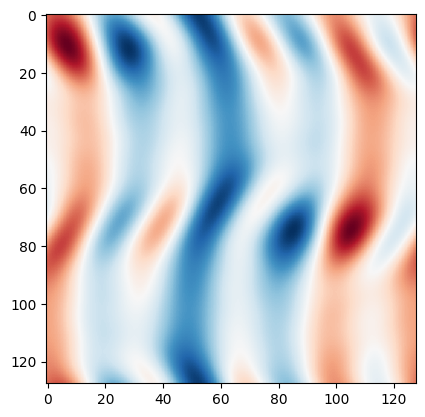

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import h5py

# video_array = np.load('../../../experiments/kol_diffore_3007/checkpoints/output_seq.npy')
hdf_file = h5py.File('../../../datasets/kol/results.h5', 'r')
video_array = hdf_file['velocity_field'][:]


print(video_array.shape)



frames = [] # for storing the generated images
fig = plt.figure()
for i in range(6000):
    # frames.append([plt.imshow(video_array[0][i][:,:,0], cmap='RdBu_r',animated=True)])
    frames.append([plt.imshow(video_array[i][:,:,0], cmap='RdBu_r',animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=5, blit=True,
                                repeat_delay=1000)
ani.save('movies.mp4')
plt.show()




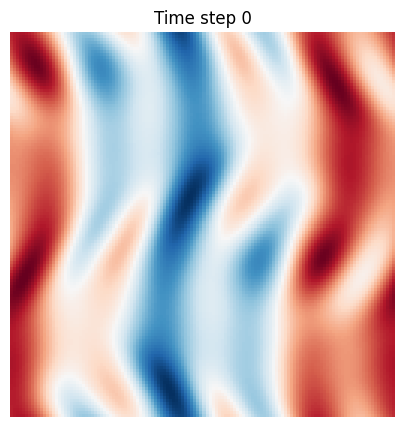

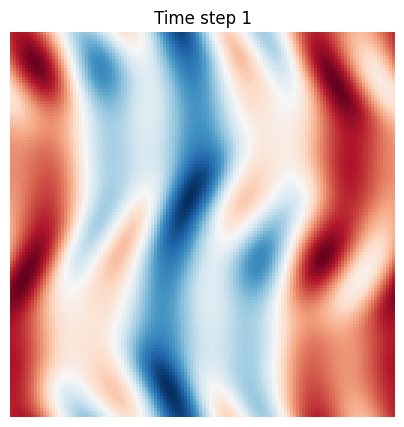

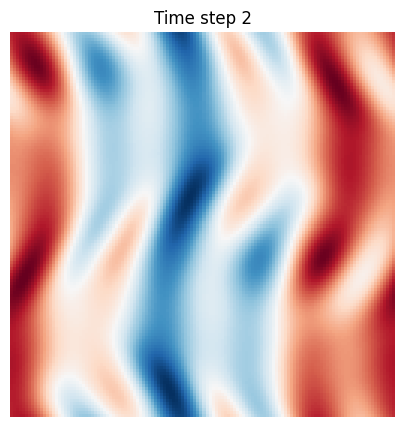

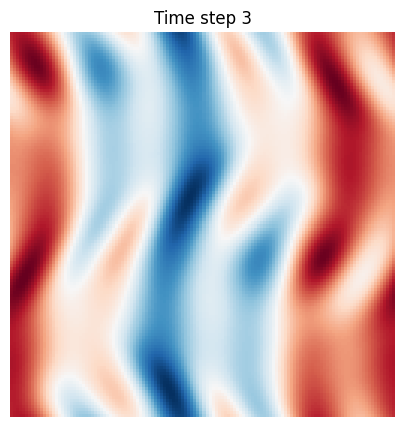

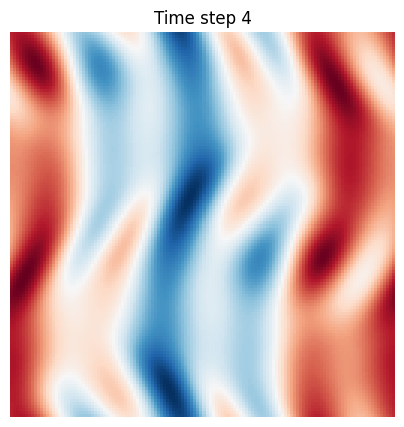

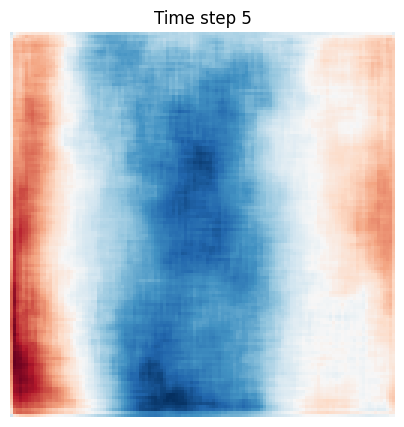

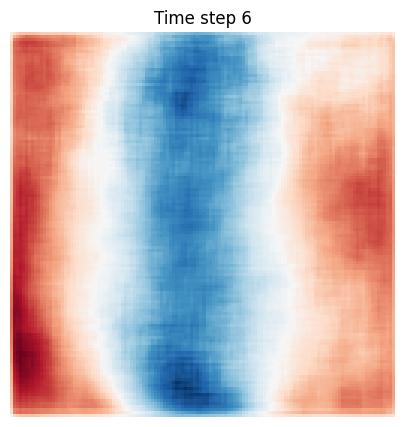

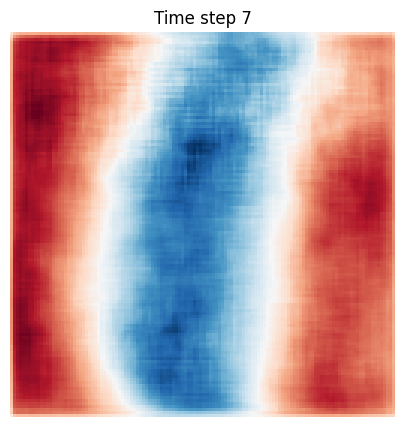

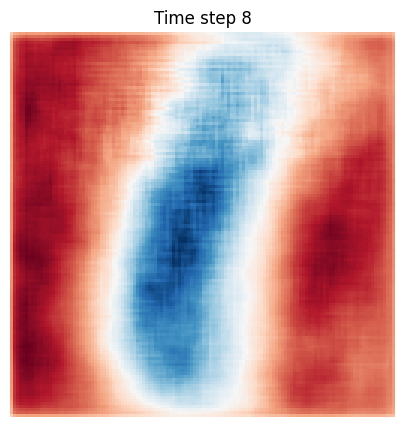

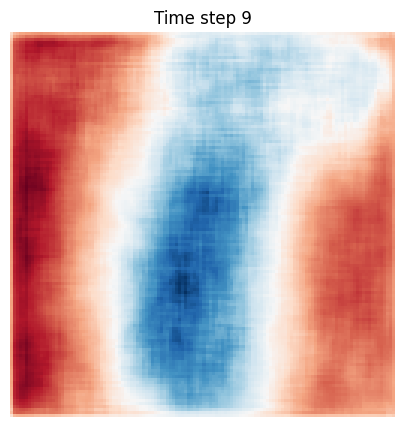

In [18]:
video_array = np.load('../../../experiments/kol_diffore_3007/checkpoints/output_seq.npy')

# Plot the images for each time step
for t in range(10):
    plt.figure(figsize=(5, 5))
    frame = video_array[0][t, :, :, 0]  # Extract the frame (H, W)
    plt.imshow(frame, cmap='RdBu_r')  # Since C=1, use grayscale
    plt.title(f'Time step {t}')
    plt.axis('off')
    plt.show()

TypeError: CuboidTransformerUNet.forward() missing 1 required positional argument: 'cond'

In [ ]:
micro_batch_size = batch.shape[self.batch_axis]
data_idx = int(batch_idx * micro_batch_size)

target_seq, cond, context_seq = self.get_input(batch, return_verbose=True)

In [ ]:




def rollout2d(
    model: torch.nn.Module,
    initial_u: torch.Tensor,
    pde: PDEDataConfig,
    time_history: int,
    num_steps: int,
):
    traj_ls = []
    pred = torch.Tensor()
    data_vector = torch.Tensor().to(device=initial_u.device)
    for i in range(num_steps):
        if i == 0:
            data_scalar = initial_u[:, :time_history]

            data = torch.cat((data_scalar, data_vector), dim=2)

        else:
            data = torch.cat((data, pred), dim=1)
            data = data[
                :,
                -time_history:,
            ]


        pred = model(data)
        traj_ls.append(pred)

    traj = torch.cat(traj_ls, dim=1)
    return traj


def cond_rollout2d(
    model: torch.nn.Module,
    initial_u: torch.Tensor,
    initial_v: torch.Tensor,
    delta_t: Optional[torch.Tensor],
    cond: Optional[torch.Tensor],
    grid: Optional[torch.Tensor],
    pde: PDEDataConfig,
    time_history: int,
    num_steps: int,
):
    traj_ls = []
    pred = torch.Tensor().to(device=initial_u.device)
    data_vector = torch.Tensor().to(device=initial_u.device)
    for i in range(num_steps):
        if i == 0:
            if pde.n_scalar_components > 0:
                data_scalar = initial_u[:, :time_history]
            if pde.n_vector_components > 0:
                data_vector = initial_v[
                    :,
                    :time_history,
                ]

            data = torch.cat((data_scalar, data_vector), dim=2)

        else:
            data = torch.cat((data, pred), dim=1)
            data = data[
                :,
                -time_history:,
            ]

        if grid is not None:
            data = torch.cat((data, grid), dim=1)

        if delta_t is not None:
            pred = model(data, delta_t, cond)
        else:
            pred = model(data, cond)
        traj_ls.append(pred)

    traj = torch.cat(traj_ls, dim=1)
    return traj


def rollout3d_maxwell(
    model: torch.nn.Module,
    initial_d: torch.Tensor,
    initial_h: torch.Tensor,
    time_history: int,
    num_steps: int,
):
    traj_ls = []
    pred = torch.Tensor()
    for i in range(num_steps):
        if i == 0:
            data = torch.cat((initial_d, initial_h), dim=2)
        else:
            data = torch.cat((data, pred), dim=1)  # along time
            data = data[
                :,
                -time_history:,
            ]

        pred = model(data)
        traj_ls.append(pred)

    traj = torch.cat(traj_ls, dim=1)
    return traj